# Analisis Sentimen Pengguna Twitter terhadap ABC Provider

## About ABC Provider
---

ABC Provider adalah perusahaan asal Indonesia yang menyediakan layanan seluler dan internet. Layanan selulernya mencakup telepon, SMS, dan paket data, sementara layanan internetnya mencakup koneksi broadband untuk rumah dan bisnis. ABC Provider terus mengembangkan jaringannya, menghadirkan teknologi terbaru seperti 4G dan 5G, serta berusaha memberikan pelayanan terbaik bagi pelanggannya di seluruh Indonesia.

## Business Question
---

1. Bagaimana kualitas jaringan ABC Provider dirasakan oleh pelanggan di berbagai wilayah?
    - Apakah pelanggan merasa jaringan cukup kuat dan stabil, terutama di luar kota besar?
2. Apakah harga paket ABC Provider sudah sesuai dengan harapan dan kebutuhan pelanggan?
    - Apakah pelanggan merasa harga layanan sebanding dengan manfaat yang mereka dapatkan?
3. Bagaimana pengalaman pelanggan saat berhubungan dengan layanan pelanggan ABC Provider?
    - Apakah mereka merasa dilayani dengan cepat, ramah, dan masalahnya diselesaikan dengan baik?

## Goals
---
1. Tingkatkan Persepsi Positif Terhadap Jaringan
    - Pelanggan merasa jaringan ABC Provider bagus di kota, tapi masih lemah di daerah terpencil. Perusahaan perlu memperluas dan memperkuat jaringan di area yang sering bermasalah. Selain itu, penting juga untuk memberi tahu pelanggan tentang perkembangan perbaikan jaringan agar mereka merasa diperhatikan.
2. Sesuaikan Harga dan Paket Layanan dengan Kebutuhan Pelanggan
    - Walau harga layanan cukup terjangkau, pelanggan ingin lebih banyak pilihan paket dan promo. ABC Provider bisa menyesuaikan paket berdasarkan kebutuhan pelanggan, misalnya untuk pelajar, pekerja, atau bisnis. Promo menarik juga bisa bantu menarik dan mempertahankan pelanggan.
3. Perbaiki Kualitas dan Responsivitas Layanan Pelanggan
    - Beberapa pelanggan merasa layanan pelanggan masih kurang cepat dan kurang ramah. Perusahaan bisa memberikan pelatihan tambahan untuk tim customer service dan mempercepat proses lewat chatbot atau sistem pelaporan. Evaluasi rutin juga bisa bantu tahu apa yang perlu ditingkatkan.

## Roleplay
---
Divisi marketing meminta PR Agency untuk membantu menangani opini negatif tentang ABC Provider, terutama soal jaringan, harga, dan layanan pelanggan. PR Agency diminta memantau media sosial dan forum secara aktif untuk melihat keluhan yang muncul dan mengelompokkannya sesuai isu.

Setiap respon terhadap keluhan harus cepat, sopan, dan menunjukkan empati. Jika ada isu besar atau salah paham, bantu buatkan konten klarifikasi atau edukasi agar pelanggan paham situasinya.

Jika masalah berkembang jadi krisis, PR Agency harus siap dengan pernyataan resmi dan rencana penanganan. Selain itu, bantu juga menciptakan opini positif, seperti lewat testimoni pelanggan atau dukungan influencer

## Analisa Data
---
Eksplorasi dan Persiapan Data untuk Analisis Sentimen

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
# from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from nltk.tokenize import word_tokenize # tokenisasi
from nltk.corpus import stopwords # deteksi stopword
from nltk.stem import SnowballStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [46]:
# data load

df = pd.read_csv('dataset_tweet_sentiment_cellular_service_provider.csv')
df.head()

,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


### Case Folding
Mengubah semua huruf menjadi huruf kecil (lowercase) dan menghilang teks karakter yang tidak 
diperlukan untuk menyamakan format teks

In [47]:
# membuat function untuk mengubah seua huruf menjadi huruf kecil dan menghilkang kan teks karakter yang tidak diperlukan

def text_cleaning(text):
    text = text.lower()
    text = text.replace('<user_mention>', '')
    text = text.replace('<provider_name>', '')
    text = text.replace('<product_name>', '')
    text = text.replace('<url>', '')
    
    text = text.replace('..', ' ')
    text = text.replace('...', ' ')
    text = text.replace('....', ' ')
    
    text = text.encode('ascii', 'replace').decode('ascii') # remove non ASCII (emoticon, chinese word, .etc)
    text = text.replace(r'\d+', "") # remove digits
    text = text.translate(str.maketrans("","",string.punctuation)) #remove punctuation
    text = text.strip() # remove whitespace from the beginning and end
    text = re.sub(r'\s+',' ', text) # remove multiple whitespace

    return text

In [48]:
# menmbuat kolom baru menggunakan function text_cleaning

df['text_clean'] = df['Text Tweet'].apply(lambda x: text_cleaning(x))

In [49]:
# output teks yang sudah dilakukan case folding

df[['text_clean']].head()

,text_clean
0,boikot gunakan produk bangsa sendiri
1,saktinya balik lagi alhamdulillah v
2,selamat pagi bisa bantu kenapa di dalam kamar sinyal 4g hilang yang 1 lagi panggilan darurat saja
3,dear akhir2 ini jaringan data lemot banget padahal h
4,selamat malam pendusta


### Stopwords
Menghapus kata-kata umum yang tidak memberikan nilai informasi atau sentimen.

In [50]:
# load kamus stopwords menggunakan tala

tala = pd.read_csv('StopWords_Tala.csv')
tala.head()

,LEMA
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [51]:
# unpack kolom lema

stopwords_tala = set(tala['LEMA'])
stopwords_tala

{'menilis',
 'diaama',
 'guntari',
 'sampaix',
 'ifi',
 'sosisal',
 'yulianta',
 'mngunci',
 'amgkt',
 'mising',
 'lewatt',
 'keliarahan',
 'paarkir',
 'naibaho',
 'disekililing',
 'melunasinya',
 'gubernir',
 'superstore',
 'ngenyek',
 'nunu',
 'kelanjutann',
 'ghaliya',
 'pembukuaan',
 'ambonya',
 'disurilang',
 'commisioner',
 'bynk',
 'wakoduk',
 'memperkumpulkan',
 'banhkubdi',
 'assembling',
 'mobilmogok',
 'jatirasari',
 'camatny',
 'assalim',
 'fau',
 'minoristas',
 'dayro',
 'programa',
 'kulkasnya',
 'dalamnyaconfusion',
 'daerh',
 'asbak',
 'jaenal',
 'kasiann',
 'surian',
 'kopaskong',
 'rawasaei',
 'melenggang',
 'pertan',
 'ygkedua',
 'pohonrimbum',
 'masingx',
 'disaung',
 'mdptkn',
 'melewatu',
 'nhmas',
 'renfaanramlan',
 'yukkitajaga',
 'konglomerat',
 'alfarmart',
 'perdanakusima',
 'habayahan',
 'diberikam',
 'menelusurinya',
 'dpaling',
 'kencemg',
 'loo',
 'pintupun',
 'kerua',
 'wasiman',
 'grobag',
 'tempelans',
 'karantinawilayah',
 'kemenhum',
 'knyataannya',


In [52]:
# membuat function untuk mengaplikasikan kamus tala ke dalam data teks
def remove_stopwords(text):
    return ' '.join([i for i in text if i not in stopwords_tala])

In [53]:
# membuat kolom baru dengan mengaplikasikan function remove_stopwords

df['tweet_tala'] = df['text_clean'].apply(lambda x: remove_stopwords(x.split()))
df[['tweet_tala']].head()

,tweet_tala
0,boikot produk bangsa
1,saktinya alhamdulillah v
2,pagi bantu kamar sinyal 4g hilang 1 panggilan darurat
3,akhir2 jaringan data lemot h
4,malam


### Stem
Proses stemming dilakukan dengan menggunakan kamus atau kosakata khusus untuk mengubah kata berimbuhan menjadi kata dasar. Langkah ini penting untuk menyamakan bentuk kata agar analisis sentimen lebih akurat.

In [54]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem(text):
    """
    :param text:
    :return: stemmed text
    """
    return stemmer.stem(text)

In [74]:
# membuat kolom baru tweet stem tala

df['tweet_stem_tala'] = df['tweet_tala'].apply(lambda x: stem(x))
df[['tweet_stem_tala']].head()

,tweet_stem_tala
0,boikot produk bangsa
1,sakti alhamdulillah v
2,pagi bantu kamar sinyal 4g hilang 1 panggil darurat
3,akhir2 jaring data lot h
4,malam


In [59]:
df.head()

,Id,Sentiment,Text Tweet,text_clean,tweet_tala,tweet_stem_tala
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>,boikot gunakan produk bangsa sendiri,boikot produk bangsa,boikot produk bangsa
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>",saktinya balik lagi alhamdulillah v,saktinya alhamdulillah v,sakti alhamdulillah v
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>,selamat pagi bisa bantu kenapa di dalam kamar sinyal 4g hilang yang 1 lagi panggilan darurat saja,pagi bantu kamar sinyal 4g hilang 1 panggilan darurat,pagi bantu kamar sinyal 4g hilang 1 panggil darurat
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!,dear akhir2 ini jaringan data lemot banget padahal h,akhir2 jaringan data lemot h,akhir2 jaring data lot h
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta,malam,malam


In [60]:
# membuat dataframe baru untuk sentiment

df_pos = df[df['Sentiment'] == 'positive']
df_pos

,Id,Sentiment,Text Tweet,text_clean,tweet_tala,tweet_stem_tala
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>,boikot gunakan produk bangsa sendiri,boikot produk bangsa,boikot produk bangsa
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>",saktinya balik lagi alhamdulillah v,saktinya alhamdulillah v,sakti alhamdulillah v
6,7,positive,"<PROVIDER_NAME> aku pakai <PROVIDER_NAME>, paket <PRODUCT_NAME> nya udah off tapi gantinya ada paket <PRODUCT_NAME> yg bisa gratisan youtube, senang banget <PROVIDER_NAME>",aku pakai paket nya udah off tapi gantinya ada paket yg bisa gratisan youtube senang banget,pakai paket udah off gantinya paket gratisan youtube senang,pakai paket udah off ganti paket gratis youtube senang
16,17,positive,<PROVIDER_NAME> <PROVIDER_NAME> kangen nih dapat kiriman pos marchandes nya <PROVIDER_NAME> langsung dari pak pos nya,kangen nih dapat kiriman pos marchandes nya langsung dari pak pos nya,kangen kiriman pos marchandes langsung pos,kangen kirim pos marchandes langsung pos
22,23,positive,Jadi stabil disini. <PROVIDER_NAME> <URL>,jadi stabil disini,stabil,stabil
23,24,positive,#CUG <PROVIDER_NAME> #Community Sangat Cocok Buat Komunikasi Antar :. - Keluarga. - Rekan Bisnis / Kerja. - Sekolah / Kampus. - Hubungan Jarak.,cug community sangat cocok buat komunikasi antar keluarga rekan bisnis kerja sekolah kampus hubungan jarak,cug community cocok komunikasi keluarga rekan bisnis kerja sekolah kampus hubungan jarak,cug community cocok komunikasi keluarga rekan bisnis kerja sekolah kampus hubung jarak
32,33,positive,"Hore,,, Akhirnya ada sinyal 4G <PROVIDER_NAME> di Sambu",hore akhirnya ada sinyal 4g di sambu,hore sinyal 4g sambu,hore sinyal 4g sambu
33,34,positive,Alhamdulilah dikunjungi para vendor mitra <PROVIDER_NAME> ke #klinikKUMSda… <URL>,alhamdulilah dikunjungi para vendor mitra ke klinikkumsda,alhamdulilah dikunjungi vendor mitra klinikkumsda,alhamdulilah kunjung vendor mitra klinikkumsda
41,42,positive,<PROVIDER_NAME> 1berbagi tanpa kuota 2 berbagai kapan saja <PROVIDER_NAME> bagi berkah <USER_MENTION>,1berbagi tanpa kuota 2 berbagai kapan saja bagi berkah,1berbagi kuota 2 berkah,1berbagi kuota 2 berkah
42,43,positive,"<PROVIDER_NAME> bagi berkah 1video ngabuburit dengan anak, video sahur bersama keluarga, video pakai baju koko baru, <USER_MENTION>",bagi berkah 1video ngabuburit dengan anak video sahur bersama keluarga video pakai baju koko baru,berkah 1video ngabuburit anak video sahur keluarga video pakai baju koko,berkah 1video ngabuburit anak video sahur keluarga video pakai baju koko


In [61]:
# membuat dataframe baru untuk sentiment negatif

df_neg = df[df['Sentiment'] == 'negative']
df_neg

,Id,Sentiment,Text Tweet,text_clean,tweet_tala,tweet_stem_tala
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>,selamat pagi bisa bantu kenapa di dalam kamar sinyal 4g hilang yang 1 lagi panggilan darurat saja,pagi bantu kamar sinyal 4g hilang 1 panggilan darurat,pagi bantu kamar sinyal 4g hilang 1 panggil darurat
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!,dear akhir2 ini jaringan data lemot banget padahal h,akhir2 jaringan data lemot h,akhir2 jaring data lot h
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta,malam,malam
5,6,negative,Untuk penembakan paket dari <PRODUCT_NAME> masih gangguan ya <PROVIDER_NAME>,untuk penembakan paket dari masih gangguan ya,penembakan paket gangguan,tembak paket ganggu
7,8,negative,RT <USER_MENTION>: <PROVIDER_NAME> tak ada lagi dalam kamus perhapean saya. #Boikot<PROVIDER_NAME> <URL>,rt tak ada lagi dalam kamus perhapean saya boikot,rt kamus perhapean boikot,rt kamus perhapean boikot
8,9,negative,keluhan gak ditanggapi. bikin emosi aja. pulsaku dicuri terus. soak deh. masa setiap hari pulsa berkurang 1500-2100 bisa 2-3*/hari,keluhan gak ditanggapi bikin emosi aja pulsaku dicuri terus soak deh masa setiap hari pulsa berkurang 15002100 bisa 23hari,keluhan gak ditanggapi bikin emosi pulsaku dicuri deh pulsa berkurang 15002100 23hari,keluh gak tanggap bikin emosi pulsa curi deh pulsa kurang 15002100 23hari
9,10,negative,#Bilboard iklan <PROVIDER_NAME> kok ada pesan tersembunyi? #Boikot<PROVIDER_NAME> #Ramadhan <URL>,bilboard iklan kok ada pesan tersembunyi boikot ramadhan,bilboard iklan pesan tersembunyi boikot ramadhan,bilboard iklan pesan sembunyi boikot ramadhan
10,11,negative,"<PROVIDER_NAME> mampus!!!!! bulan puasa, subuh2 mau sahur cek pulsa tersedot terus. dan sekarang sisa 30 ribu <PROVIDER_NAME> Tolong dibaca!!!",mampus bulan puasa subuh2 mau sahur cek pulsa tersedot terus dan sekarang sisa 30 ribu tolong dibaca,puasa subuh2 sahur cek pulsa tersedot sisa 30 ribu dibaca,puasa subuh2 sahur cek pulsa sedot sisa 30 ribu baca
11,12,negative,<USER_MENTION> Pernah coba pakai <PROVIDER_NAME> tapi parah koneksinya,pernah coba pakai tapi parah koneksinya,coba pakai parah koneksinya,coba pakai parah koneksi
12,13,negative,"Setuju, <USER_MENTION> silahkan boikot saja pelanggan <PROVIDER_NAME> pendukung #HRS <URL>",setuju silahkan boikot saja pelanggan pendukung hrs,setuju silahkan boikot pelanggan pendukung hrs,tuju silah boikot langgan dukung hrs


In [62]:
def kamus(check):
    check = check.str.extractall('([a-zA_Z]+)')
    check.columns = ['check']
    b = check.reset_index(drop=True)
    check = b['check'].value_counts()

    kamus = {'kata':check.index,'freq':check.values}
    kamus = pd.DataFrame(kamus)
    kamus.index = kamus['kata']
    kamus.drop('kata', axis = 1, inplace = True)
    kamus.sort_values('freq',ascending=False,inplace=True)

    return kamus

In [63]:
kamus_unclean_pos = kamus(df_pos['tweet_stem_tala'])
kamus_unclean_neg = kamus(df_neg['tweet_stem_tala'])

In [64]:
kamus_unclean_pos.head()

,freq
kata,
pakai,27
gratis,21
lancar,20
sinyal,17
g,17


In [65]:
kamus_unclean_neg.head()

,freq
kata,
g,35
jaring,31
boikot,26
sinyal,24
gak,24


<Axes: ylabel='kata'>

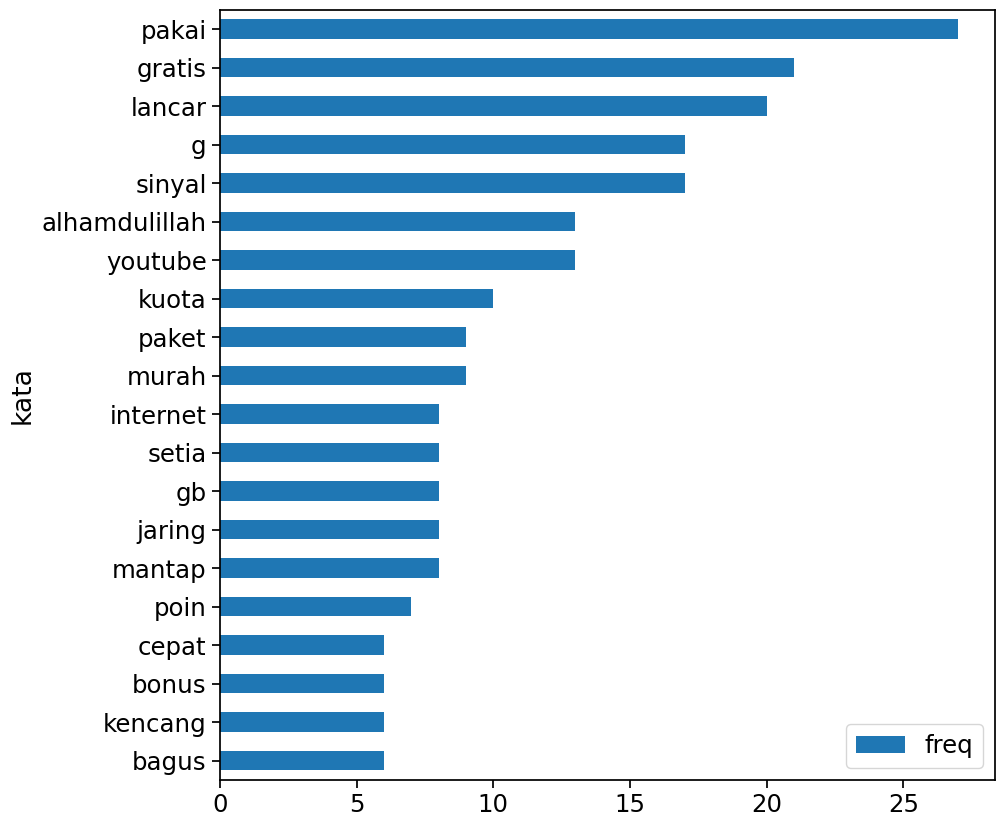

In [66]:
sns.set_context(context = 'notebook', font_scale = 1.6)
kamus_unclean_pos[:20].sort_values(by = 'freq', ascending = True).plot(kind = 'barh',figsize = (10,10))

Insight dari Grafik Opini Positif:

- Kata paling sering muncul: "pakai", "gratis", "lancar", "sinyal", "youtube", "alhamdulillah".

- Banyak pengguna mengekspresikan kepuasan terhadap kemudahan penggunaan, bonus/promo, dan jaringan yang lancar.

- Kata seperti "murah", "cepat", "kuota", "bonus", "bagus" menunjukkan bahwa layanan dirasa terjangkau dan memuaskan bagi sebagian pengguna.

<Axes: ylabel='kata'>

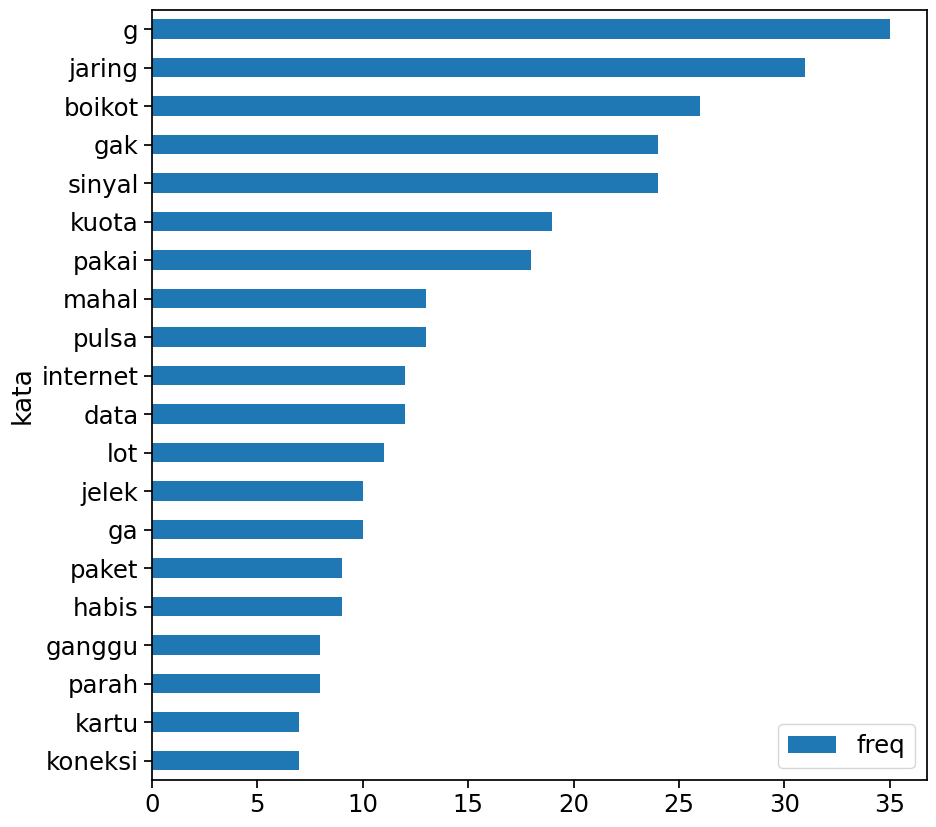

In [67]:
sns.set_context(context = 'notebook', font_scale = 1.6)
kamus_unclean_neg[:20].sort_values(by = 'freq', ascending = True).plot(kind = 'barh',figsize = (10,10))

Insight dari Grafik Opini Negatif:

- Kata dominan: "g", "jaring", "boikot", "gak", "mahal", "jelek", "ganggu", "habis".

- Keluhan utama berkaitan dengan jaringan (sinyal, koneksi, gangguan), harga mahal, dan kuota cepat habis.

- Muncul kata emosional seperti "boikot", "jelek", "parah", "gak" yang menunjukkan frustrasi pengguna.

In [68]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")

In [69]:
word_cloud_pos = WordCloud(background_color='white').generate(str(df_pos['tweet_stem_tala']))

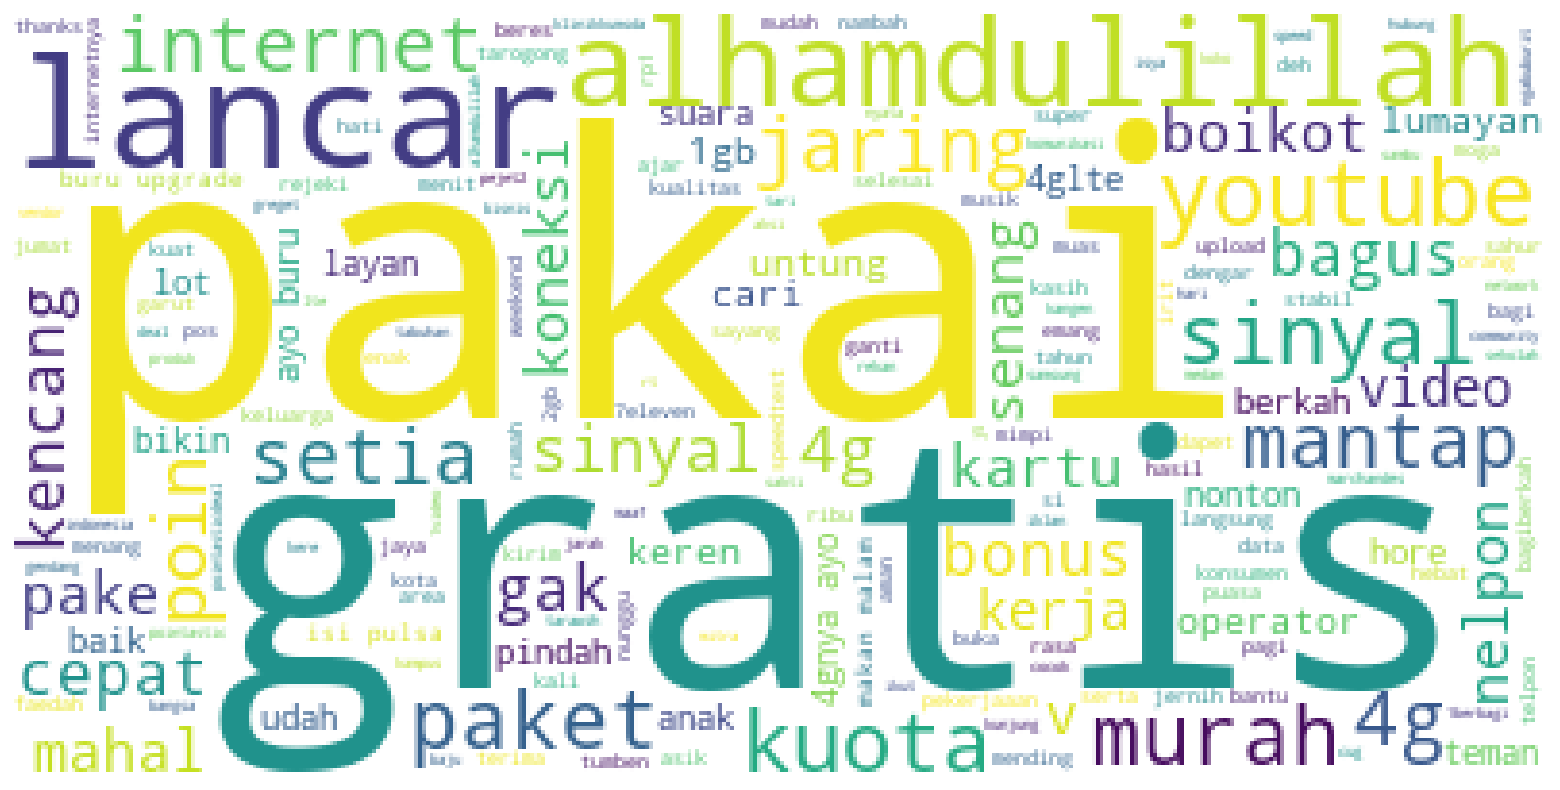

In [70]:
plot_cloud(word_cloud_pos)

Insight : Kata paling sering muncul "pakai", "gratis", "lancar", "sinyal", "youtube", "alhamdulillah".

In [71]:
word_cloud_neg = WordCloud(background_color='white').generate(str(df_neg['tweet_stem_tala']))

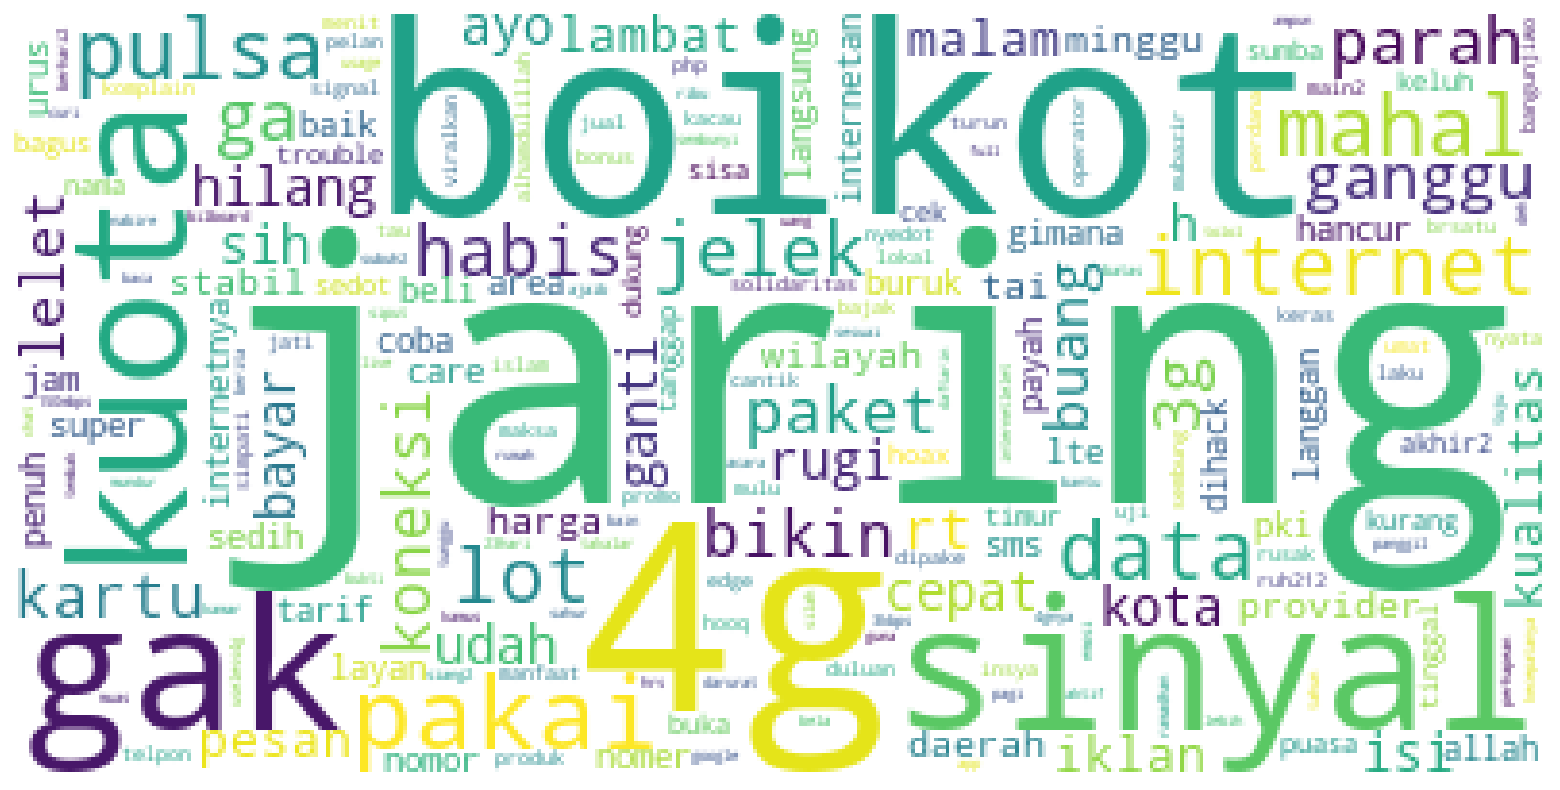

In [72]:
plot_cloud(word_cloud_neg)

Insight : Kata yang paling sering muncul adalah "g", "jaring", "boikot", "gak", "mahal", "jelek", "ganggu", "habis"

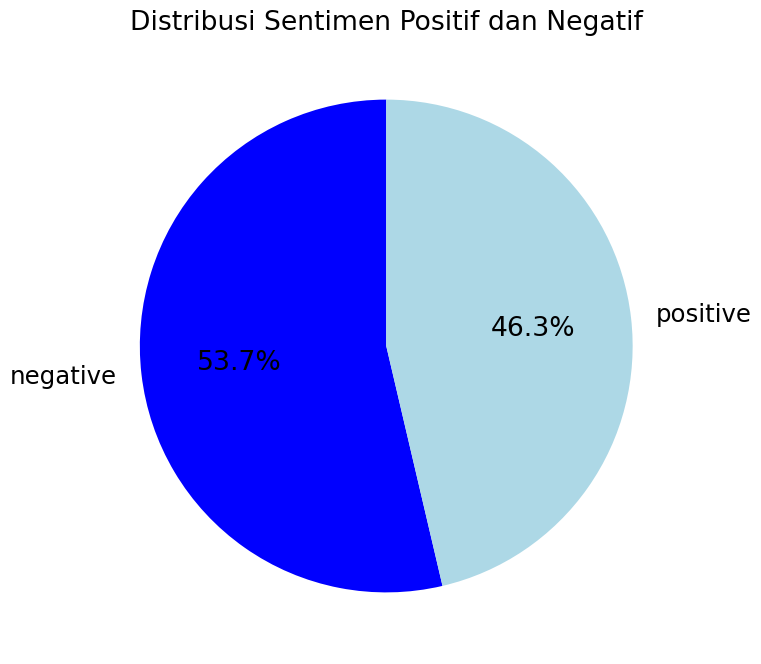

In [73]:
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'lightblue'])
plt.title('Distribusi Sentimen Positif dan Negatif')
plt.show()

Insight : Sentimen negatif (53.7%) sedikit lebih banyak dibandingkan sentimen positif (46.3%).

## Kesimpulan:

Analisis menunjukkan bahwa banyak pengguna mengeluhkan koneksi internet yang lambat, harga layanan yang tinggi, dan masalah sinyal. Sentimen negatif seperti "jelek" dan "boikot" mencerminkan ketidakpuasan yang tinggi. Hal ini dapat merusak reputasi penyedia layanan dan membuat pelanggan berpindah ke kompetitor. Untuk memperbaiki situasi, penting untuk meningkatkan kecepatan jaringan, meninjau harga layanan, dan memberikan transparansi mengenai kuota data

- Sentimen Negatif Mendominasi
    -  Pengguna banyak mengeluhkan koneksi internet yang lambat, harga yang mahal, sinyal yang sering hilang, dan kebingungan soal kuota data. Masalah-masalah ini menunjukkan ketidakpuasan terhadap layanan yang diberikan.
    -  Tweet negatif didominasi kata seperti “jaringan”, “boikot”, dan “gangguan”. Ini menandakan banyak pengguna kecewa dan tidak puas dengan layanan yang mereka terima.
- Risiko Reputasi
    - Sentimen negatif yang terus muncul bisa merusak citra provider. Jika tidak segera diperbaiki, pengguna bisa beralih ke layanan lain yang dianggap lebih baik.

## Rekomendasi:

Untuk mengatasi masalah yang muncul, provider perlu meningkatkan kualitas jaringan agar lebih cepat dan stabil. Peninjauan ulang terhadap harga juga penting agar lebih sesuai dengan daya beli pengguna. Selain itu, informasi tentang pembagian kuota harus dibuat lebih jelas dan mudah dipahami. Di sisi lain, tim layanan pelanggan juga perlu lebih responsif di media sosial agar keluhan pengguna bisa segera ditangani.

- Tingkatkan kualitas jaringan
    - Perbaiki kecepatan dan kestabilan koneksi, terutama di wilayah dengan banyak keluhan
- Evaluasi harga dan kuota
    - Sesuaikan harga agar lebih kompetitif dan jelaskan pembagian kuota dengan cara yang mudah dimengerti.
- Perkuat respon layanan
    - Tanggap terhadap keluhan pengguna di media sosial untuk menjaga kepuasan dan kepercayaan